# CIFAR-10 이미지 생성하기
---
앞서 배운 FASHION-MNIST 모델 생성용 DCGAN 모델 구조 이용하여 CIFAR-10 데이터를 생성하는 모델을 만들어본다  

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

In [1]:
# 필요한 라이브러리 가져오기
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## STEP 1. 작업환경 구성하기
---


In [2]:
# 터미널에 입력
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

## STEP 2. 데이터셋 구성하기
---


In [3]:
# CIFAR-10 데이터셋 불러오기

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [4]:
# 학습에 사용할 train_x의 이미지를 -1, 1로 정규화

train_x = (train_x - 127.5) / 127.5

print('max pixel:', train_x.max()) # 최대 픽셀 값
print('min pixel:', train_x.min()) # 최소 픽셀 값

max pixel: 1.0
min pixel: -1.0


In [5]:
# train_x의 shape 확인
train_x.shape

(50000, 32, 32, 3)

In [6]:
train_x[0].shape

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

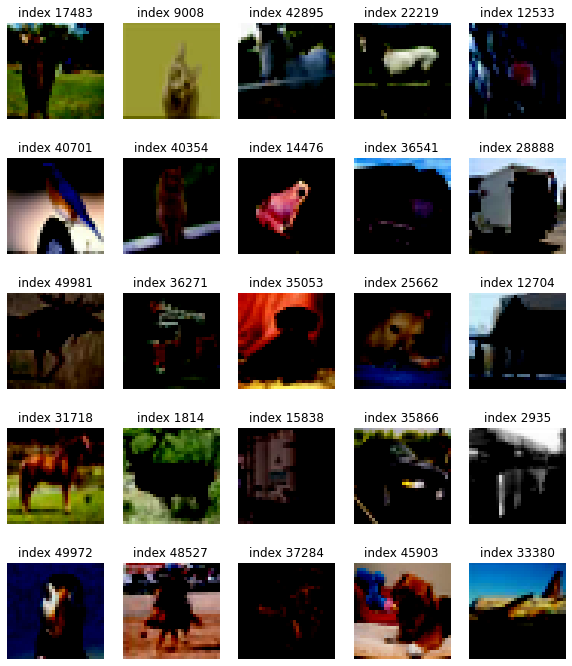

In [7]:
# 로드한 학습 데이터를 시각화를 통해 확인
# 50000개 중 랜덤으로 25개 뽑아본다


plt.figure(figsize=(10, 12))

for i in range(25):
    idx = np.random.randint(0, 50000, 25)
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[idx[i]])
    plt.title(f'index {idx[i]}')
    plt.axis('off') # 이미지의 눈금 지우기

plt.show()

## STEP 3. 생성자 모델 구현하기
---

In [8]:
# tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    # 입력값으로 노이즈를 받음
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8, 8, 256))) # Conv 연산 하도록 1차원벡터 > 3차원벡터로 변환
    
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding='same', use_bias=False,\
                                    activation='tanh'))
    
    return model

In [10]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [11]:
# 위에서 만든 generator 모델로 이미지를 생성해보자
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print('생성된 이미지의 shape:', generated_image.shape)

생성된 이미지의 shape: (1, 32, 32, 3)


In [12]:
generated_image[0].shape

TensorShape([32, 32, 3])

In [13]:
img = np.squeeze(generated_image)
img.shape
# 픽셀값을 [0,1]범위로 스케일링
img = (img + 1) /2.0
img

array([[[0.5002586 , 0.49912265, 0.49882656],
        [0.50063026, 0.50004107, 0.50153714],
        [0.5007146 , 0.5000121 , 0.49908447],
        ...,
        [0.49987307, 0.50402844, 0.5003401 ],
        [0.49961   , 0.49805507, 0.4981383 ],
        [0.5005649 , 0.50034475, 0.5030819 ]],

       [[0.50040805, 0.50139165, 0.50016063],
        [0.5012825 , 0.5005336 , 0.50130844],
        [0.49762207, 0.50032586, 0.5000821 ],
        ...,
        [0.50108886, 0.49884394, 0.50113034],
        [0.49766013, 0.5023942 , 0.49906313],
        [0.49727508, 0.49698722, 0.502113  ]],

       [[0.5024966 , 0.50220644, 0.49953583],
        [0.50004506, 0.49905902, 0.49962714],
        [0.5013643 , 0.50116724, 0.4996735 ],
        ...,
        [0.50141066, 0.50448513, 0.49878225],
        [0.5003572 , 0.50330114, 0.49991244],
        [0.49756432, 0.50102854, 0.49871865]],

       ...,

       [[0.4995579 , 0.50167197, 0.5004687 ],
        [0.49952853, 0.50147295, 0.5019929 ],
        [0.50152594, 0

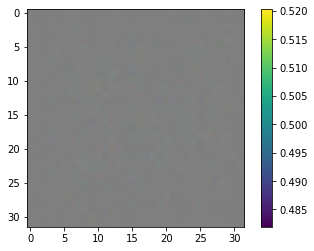

In [14]:
# 생성된 이미지를 시각화해보자
# plt.imshow(generated_image[0])
plt.imshow(img)
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현하기
---
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [15]:
# 판별자 모델 생성 함수

def make_discriminator_model():
    
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [16]:
# 판별자 생성
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        

In [17]:
generated_image.shape

TensorShape([1, 32, 32, 3])

In [18]:
# 아까 생성한 가짜이미지를 입력해 판별시켜보자
dicision = discriminator(generated_image, training=False)
dicision

# 0.00274846

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4995098]], dtype=float32)>

## STEP 5. 손실함수와 최적화 함수 구현하기
---
- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

### 손실함수 구현

In [19]:
## 손실함수로 cross_entropy 생성
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
# 생성자의 손실함수 : fake_output이 실제에 가까울수록 리턴하는 로스값은 작은 값을 가짐
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
# 판별자의 손실함수 : 진짜를 진짜로, 가짜를 가짜로 잘 판별해야 전체 loss가 낮아진다
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

### 정확도 계산 함수 구현

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(
        tf.cast(
            tf.math.greater_equal(
                real_output, tf.constant([0.5])), tf.float32))
    
    fake_accuracy = tf.reduce_mean(
        tf.cast(
            tf.math.less(fake_output, tf.constant([0.5])),
                tf.float32))
    
    return real_accuracy, fake_accuracy

### 최적화함수 정의

In [23]:
# 생성자와 판별자를 최적화하는 optimizer를 정의 (lr = 0.00001)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
noise_dim = 100 # 노이즈의 차원수
num_examples_to_generate = 16 # 한 번에 생성할 샘플 수

seed = tf.random.normal([num_examples_to_generate, noise_dim]) # 정규분포에서 해당 shape의 무작위수 추출
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기
---
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.


In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape(persistent=True) as gen_tape, tf.GradientTape(persistent=True) as disc_tape: #(3) tf.GradientTape()오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True) # 판별자가 생성된 이미지 판별

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output) # 진짜와 가짜에 대한 판별자의 손실 계산

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = gen_tape.gradient(disc_loss, discriminator.trainable_variables)
    # 판별자의 훈련가능한 변수에 대한 손실의 기울기를 계산
    
    # GradientTape 삭제
    del gen_tape
    del disc_tape
    
    
    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # 판별자의 최적화 기울기를 적용
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [27]:
# 학습현황을 볼 수 있는 샘플을 생성하는 함수
# 16개 seed가 들어있는 sample_seeds 입력받아 만들어낸 prediction을 matplotlib으로 시각화
# plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :3])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [28]:
# loss, accuracy 그래프 시각화
# train_step()의 리턴값 :gen_loss, disc_loss, real_accuracy, fake_accuracy
# 위 값을 dict형식 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [29]:
# training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

checkpoint_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator
                                )

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [34]:
save_every = 5
EPOCHS = 100

# 사용사능 GPU 디바이스 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

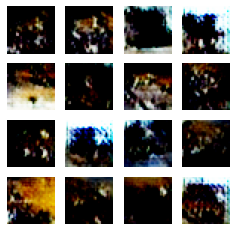

Time for training : 3279 sec


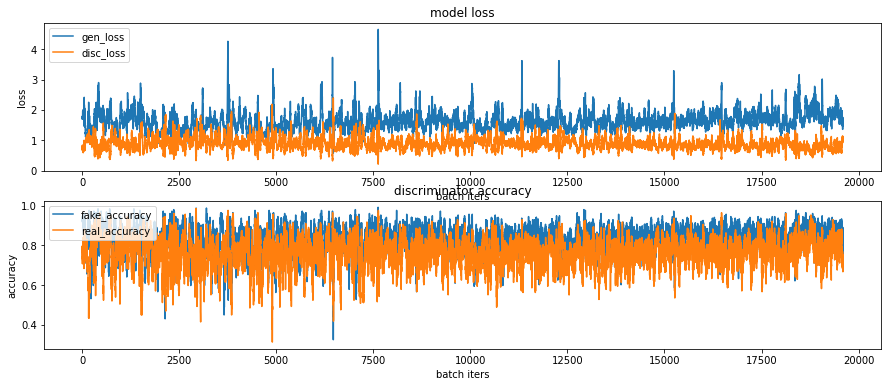

In [35]:
train(train_dataset, EPOCHS, save_every)

In [36]:
# 학습과정 시각화
# 생성한 샘플 이미지를 합쳐 GIF파일로 만든다
# imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식



anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1243311 Sep 20 10:01 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif
